In [1]:
import pandas as pd 
import geopandas as gpd
from shapely.geometry import Point
from bbox import * 
from pytz import timezone
import os
from shapely.wkt import loads
import numpy as np
import xarray as xr
import gc

# Sensor Data Only

In [2]:
sensor_df=pd.read_csv('../../data/sensor_data/hourly_raw_o3.csv', index_col=0)
sensor_df=sensor_df[['latitude', 'longitude', 'date_local',
       'time_local', 'sample_measurement', 'site_number', 'county','state']]
sensor_df=sensor_df[~sensor_df['sample_measurement'].isna()]
sensor_df['time'] = pd.to_datetime(sensor_df['date_local'] + ' ' + sensor_df['time_local'])


no2_hours = pd.read_csv("../../data/tempo_data/o3_file_hours.csv")
no2_hours=list(no2_hours['time_hr_ct'])
time_list = np.array(no2_hours, dtype="datetime64[ns]")
sensor_time_list = np.array(sensor_df['time'].unique(), dtype="datetime64[ns]")
seta = set(sensor_time_list)
setb = set(time_list)
union_set = seta & setb
full_time_list = list(union_set)
# Convert to pandas datetime objects
pd_datetime_list = list(pd.to_datetime(full_time_list))
sensor_df['time']=pd.to_datetime(sensor_df['time'])
sensor_df=sensor_df[sensor_df['time'].isin(pd_datetime_list)]

In [3]:
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    sensor_df,
    geometry=[Point(xy) for xy in zip(sensor_df["longitude"], sensor_df["latitude"])],
    crs="EPSG:4326"  # WGS84 coordinate reference system
)
gdf=gdf[['latitude','longitude','geometry']].drop_duplicates()

# Create gridded GDF
res = 0.01 
lon_bins = np.arange(lon_min+0.005, lon_max, res)
lat_bins = np.arange(lat_min+0.005, lat_max, res)

grid_cells = []
for x in lon_bins[:-1]:
    for y in lat_bins[:-1]:
        grid_cells.append(
            Point(x, y).buffer(res / 2).envelope
        )

grid_gdf = gpd.GeoDataFrame(
    {"geometry": grid_cells},
    crs="EPSG:4326"
)
grid_gdf["lat"] = grid_gdf.geometry.centroid.y
grid_gdf["lon"] = grid_gdf.geometry.centroid.x

grid_gdf["lat"] = round(grid_gdf["lat"],3)
grid_gdf["lon"] = round(grid_gdf["lon"],3)
grid_gdf=grid_gdf.drop_duplicates()
key = gpd.sjoin(grid_gdf, gdf, how="inner", predicate="intersects")
key=key[['geometry','lat','lon','latitude','longitude']]


sensor_df_joined = pd.merge(sensor_df, key, on=['latitude','longitude'], how='left')
# sensor_df_joined = sensor_df_joined[['lat', 'lon', 'time', 'sample_measurement']]
sensor_df_joined=sensor_df_joined.rename(columns={'sample_measurement':'o3'})

del gdf
del sensor_df
del grid_cells
del key
gc.collect()

sensor_df_joined.to_csv('../../data/sensor_data/final_sensor_o3_withgrid.csv')

/var/tmp/ipykernel_10120/3451328990.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf["lat"] = grid_gdf.geometry.centroid.y
/var/tmp/ipykernel_10120/3451328990.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf["lon"] = grid_gdf.geometry.centroid.x


In [ ]:
%%capture
unique_months = sorted(set(pd.to_datetime(date).to_period('M') for date in pd_datetime_list))

for i in range(len(unique_months)):
    month=unique_months[i]
    month_str=str(month)
    print(month_str)
    dates_in_month = sorted([date for date in full_time_list if str(pd.to_datetime(date).to_period('M')) == month_str])

    # Initialize an empty list to hold xarrays
    xarrays_list = []

    for i, time in enumerate(dates_in_month):
        # if i % 10 == 0:
        #     print(i)
        o3_df = sensor_df_joined[sensor_df_joined['time']==time]
        grid_gdf["lat"] = round(grid_gdf["lat"],3)
        grid_gdf["lon"] = round(grid_gdf["lon"],3)
        o3_df["lat"] = round(o3_df["lat"],3)
        o3_df["lon"] = round(o3_df["lon"],3)
        time_df = pd.merge(grid_gdf, o3_df, on=['lat', 'lon'], how='left')
        time_df=time_df.drop_duplicates()
        time_df['time'] = time_df['time'].fillna(time)

        # Pivot the data into a 2D array
        time_df_pivot = time_df.pivot(index="lat", columns="lon", values="o3")

        # Convert to xarray
        da = xr.DataArray(
            time_df_pivot.values,
            coords={
                "lat": time_df_pivot.index.values,
                "lon": time_df_pivot.columns.values,
            },
            dims=["lat", "lon"],
            name="o3"
        )
        ds_expanded = da.expand_dims({'time': [time]})
        # Append the expanded xarray to the list
        xarrays_list.append(ds_expanded)

    # Concatenate all the xarrays in the list along the 'time' dimension
    final_ds = xr.concat(xarrays_list, dim='time')

    final_ds.to_netcdf(f'../../data/y_sensor_only_o3/sensor_{month_str}.nc')
    Mo
    

# Sensor and Mobile Data

In [9]:
sensor_df_joined=pd.read_csv('../../data/sensor_data/final_sensor_o3_withgrid.csv')
mobile_df = pd.read_csv('../../data/mobile_air_data/final_mobile_withgrid_o3.csv')

sensor_df_joined = sensor_df_joined[['lat', 'lon', 'time', 'o3']]
mobile_df=mobile_df[['lat', 'lon', 'time', 'weighted_o3']]
full_df = pd.merge(sensor_df_joined, mobile_df, on=['lat', 'lon', 'time'], how='outer')
full_df['sensor?'] = np.where(full_df['o3'].isna(), 0, 1)
full_df['o3'] = full_df['o3'].fillna(full_df['weighted_o3'])
full_df.drop('weighted_o3', axis=1,inplace=True)
pd_datetime_list = list(pd.to_datetime(full_df['time']))

In [10]:
# Create gridded GDF
res = 0.01 
lon_bins = np.arange(lon_min+0.005, lon_max, res)
lat_bins = np.arange(lat_min+0.005, lat_max, res)

grid_cells = []
for x in lon_bins[:-1]:
    for y in lat_bins[:-1]:
        grid_cells.append(
            Point(x, y).buffer(res / 2).envelope
        )

grid_gdf = gpd.GeoDataFrame(
    {"geometry": grid_cells},
    crs="EPSG:4326"
)
grid_gdf["lat"] = grid_gdf.geometry.centroid.y
grid_gdf["lon"] = grid_gdf.geometry.centroid.x

grid_gdf["lat"] = round(grid_gdf["lat"],3)
grid_gdf["lon"] = round(grid_gdf["lon"],3)
full_df["lat"] = round(full_df["lat"],3)
full_df["lon"] = round(full_df["lon"],3)

/var/tmp/ipykernel_10120/2120224353.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf["lat"] = grid_gdf.geometry.centroid.y
/var/tmp/ipykernel_10120/2120224353.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf["lon"] = grid_gdf.geometry.centroid.x


In [20]:
import pandas as pd
import xarray as xr
import multiprocessing as mp

def process_month(month):
    print(month)
    month_str = str(month)
    print(f"Processing {month_str}")

    dates_in_month = sorted([
        date for date in full_time_list
        if str(pd.to_datetime(date).to_period('M')) == month_str
    ])

    xarrays_list = []

    for time in dates_in_month:
        no2_df = full_df[full_df['time'].astype(str) == str(time)]
        time_df = pd.merge(grid_gdf, no2_df, on=['lat', 'lon'], how='left')
        time_df['time'] = time_df['time'].fillna(time)

        # Pivot for o3
        no2_pivot = time_df.pivot(index="lat", columns="lon", values="o3")
        # Pivot for sensor
        sensor_pivot = time_df.pivot(index="lat", columns="lon", values="sensor?")

        # Convert to xarray DataArrays
        no2_da = xr.DataArray(
            no2_pivot.values,
            coords={"lat": no2_pivot.index.values, "lon": no2_pivot.columns.values},
            dims=["lat", "lon"],
            name="o3"
        )

        sensor_da = xr.DataArray(
            sensor_pivot.values,
            coords={"lat": sensor_pivot.index.values, "lon": sensor_pivot.columns.values},
            dims=["lat", "lon"],
            name="sensor?"
        )

        ds = xr.Dataset({"o3": no2_da, "sensor?": sensor_da})
        ds_expanded = ds.expand_dims({'time': [time]})
        xarrays_list.append(ds_expanded)

    # Combine and save
    final_ds = xr.concat(xarrays_list, dim='time')
    final_ds.to_netcdf(f'../../data/y_sensor_mobile_o3/sensor_mobile_{month_str}.nc')

# Prepare list of months
unique_months = sorted(set(pd.to_datetime(date).to_period('M') for date in pd_datetime_list))
# unique_months=unique_months[3:]

# Run in parallel
if __name__ == "__main__":
    with mp.Pool(processes=mp.cpu_count()) as pool:
        pool.map(process_month, unique_months)


In [21]:
# %%capture
# unique_months = sorted(set(pd.to_datetime(date).to_period('M') for date in pd_datetime_list))

# for i in range(len(unique_months)):
#     month=unique_months[i]
#     month_str=str(month)
#     print(month_str)
#     dates_in_month = sorted([date for date in full_time_list if str(pd.to_datetime(date).to_period('M')) == month_str])

#     # Initialize an empty list to hold xarrays
#     xarrays_list = []

#     for i, time in enumerate(dates_in_month):

#         # print(i)
#         no2_df = full_df[full_df['time'].astype(str) == str(time)]
#         time_df = pd.merge(grid_gdf, no2_df, on=['lat', 'lon'], how='left')
#         time_df['time'] = time_df['time'].fillna(time)

#         # Pivot the data for no2
#         no2_pivot = time_df.pivot(index="lat", columns="lon", values="o3")

#         # Pivot the data for sensor
#         sensor_pivot = time_df.pivot(index="lat", columns="lon", values="sensor?")

#         # Convert no2 to xarray
#         no2_da = xr.DataArray(
#             no2_pivot.values,
#             coords={
#                 "lat": no2_pivot.index.values,
#                 "lon": no2_pivot.columns.values,
#             },
#             dims=["lat", "lon"],
#             name="o3"
#         )

#         # Convert sensor to xarray
#         sensor_da = xr.DataArray(
#             sensor_pivot.values,
#             coords={
#                 "lat": sensor_pivot.index.values,
#                 "lon": sensor_pivot.columns.values,
#             },
#             dims=["lat", "lon"],
#             name="sensor?"
#         )

#         # Combine both variables into a single dataset
#         ds = xr.Dataset(
#             {
#                 "o3": no2_da,
#                 "sensor?": sensor_da,
#             }
#         )

#         # Expand dataset along the 'time' dimension
#         ds_expanded = ds.expand_dims({'time': [time]})

#         # Append the expanded xarray dataset to the list
#         xarrays_list.append(ds_expanded)

#     # Concatenate all the xarray datasets in the list along the 'time' dimension
#     final_ds = xr.concat(xarrays_list, dim='time')
#     final_ds.to_netcdf(f'../../data/y_sensor_mobile_o3/sensor_mobile_{month_str}.nc')


In [10]:
# final_ds.to_netcdf(f'../../data/mobile_air_data/full_gridded_mobile.nc', engine='h5netcdf')

In [11]:
import matplotlib.pyplot as plt
# # # Define your latitude and longitude bounds
# # lat_min, lat_max = 28.6, 33.4  # Example latitude range
# # lon_min, lon_max = -98.9, -88.3  # Example longitude range

# # Select one hour of temperature data (e.g., the first timestamp)
# hour_index = 1  # Change this to select a different hour if desired
# # temperature_data = nldas_month['temperature'].isel(time=hour_index)
# temperature_data = nldas_month['wind_u']

# Plot the data with switched axes
plt.figure(figsize=(10, 6))

# Plot with latitude on x-axis and longitude on y-axis
final_ds['no2'][0].plot(
    cmap="Reds",  # Colormap for temperature visualization
    cbar_kwargs={'label': 'Temperature (K)'}  # Add color bar label
)

# Update axis labels
plt.xlabel("Latitude")
plt.ylabel("Longitude")

plt.show()

KeyError: 'no2'

<Figure size 1000x600 with 0 Axes>

In [13]:
sensor_df_joined=pd.read_csv('../../data/sensor_data/final_sensor_withgrid.csv')
mobile_df = pd.read_csv('../../data/mobile_air_data/final_mobile_withgrid.csv')

sensor_df_joined = sensor_df_joined[['lat', 'lon', 'time', 'no2']]
mobile_df=mobile_df[['lat', 'lon', 'time', 'weighted_no2']]
full_df = pd.merge(sensor_df_joined, mobile_df, on=['lat', 'lon', 'time'], how='outer')
full_df['sensor?'] = np.where(full_df['no2'].isna(), 0, 1)

In [16]:
check = full_df[(~full_df['weighted_no2'].isna())]
check = check[(~check['no2'].isna())]

In [25]:
sensor_df_joined

,lat,lon,time,no2
0,30.045,-90.275,2023-08-02 13:00:00,3.5
1,30.045,-90.275,2023-08-04 09:00:00,1.4
2,30.045,-90.275,2023-08-04 13:00:00,1.3
3,30.045,-90.275,2023-08-04 17:00:00,3.8
4,30.045,-90.275,2023-08-05 09:00:00,1.8
...,...,...,...,...
258802,30.465,-91.175,2024-11-29 09:00:00,2.1
258803,30.465,-91.175,2024-11-29 13:00:00,1.2
258804,30.465,-91.175,2024-11-29 17:00:00,3.5
258805,30.465,-91.175,2024-11-30 09:00:00,0.9


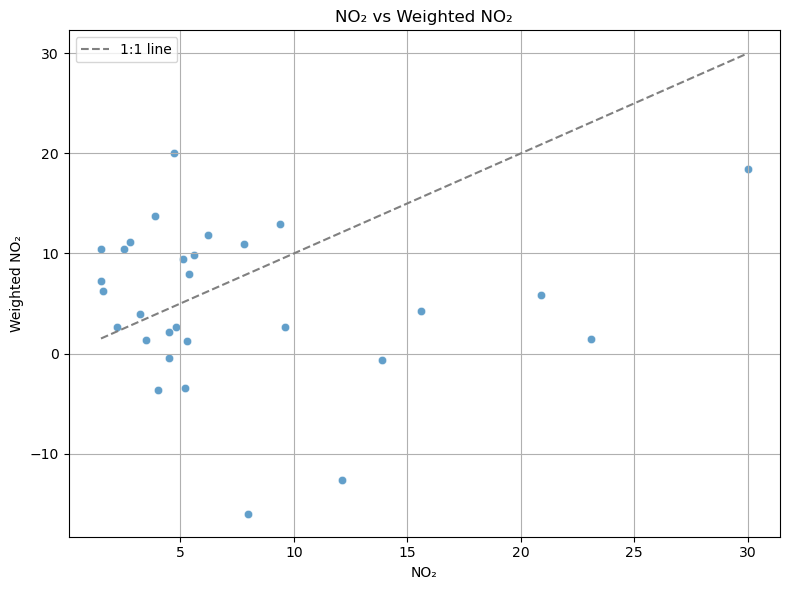

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example DataFrame (replace with your actual data)
# df = pd.read_csv("your_data.csv")  # if loading from a file

# Plotting
plt.figure(figsize=(8, 6))
sns.scatterplot(data=check, x='no2', y='weighted_no2', alpha=0.7)
plt.plot([check['no2'].min(), check['no2'].max()],
         [check['no2'].min(), check['no2'].max()],
         linestyle='--', color='gray', label='1:1 line')
plt.xlabel("NO₂")
plt.ylabel("Weighted NO₂")
plt.title("NO₂ vs Weighted NO₂")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
